In [25]:
import logging
from typing import Any, Dict, Iterator, List, Tuple

import numpy as np
from numpy.typing import NDArray
from scipy.special import sph_harm
import os
os.chdir("/zhome/71/c/146676/material_tensor_tomo")
from mumott.spherical_harmonics import SphericalHarmonics
from mumott.gaussian_kernels import GaussianKernels
import mumott.odf_geometry as odf_geometry
import mumott.geometry as geometry
import matplotlib.pyplot as plt

from cil.framework import ImageGeometry, ImageData, AcquisitionData, AcquisitionGeometry
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.operators import CompositionOperator, BlockOperator
import cil_addons.odfsh_operator as odfsh_operator
from cil.optimisation.algorithms import CGLS, SIRT
from cil.optimisation.functions import IndicatorBox

In [439]:

n_azith_bins = 1
azimuthal_angles = np.linspace(0,2*np.pi, n_azith_bins, endpoint=False)

M_rot = 128
rotations = np.linspace(0,180,M_rot)

Nx, Ny = 100,100
grid_scale = 4
K = 4*(grid_scale+1)**2
two_theta = np.linspace(0.3,1,20)
M_two_theta, M_az = len(two_theta),len(azimuthal_angles)
M = M_two_theta*M_az
px, py = 1.0, 1.0


og = odf_geometry.ODFGeometry(azimuthal_angles=azimuthal_angles,  grid_scale=grid_scale, kernel_scale_parameter=0.3, two_theta=two_theta, rotation = rotations)

ig_M = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=M, center_x=0, center_y=0, center_z=0)
ig_K = ImageGeometry(voxel_num_x=Nx, voxel_num_y=Ny, voxel_num_z=K, center_x=0, center_y=0, center_z=0)
ag_K = AcquisitionGeometry.create_Parallel3D() \
    .set_panel(num_pixels=(Nx, K), pixel_size=(px, py)) \
    .set_angles(rotations) \
    .set_labels(['vertical','angle', 'horizontal'])
ag_M = AcquisitionGeometry.create_Parallel3D() \
    .set_panel(num_pixels=(Nx, M), pixel_size=(px, py)) \
    .set_angles(rotations) \
    .set_labels(['angle', 'horizontal', 'vertical'])

B = odfsh_operator.ODFGKOperator2d_fast_ag(odf_geometry=og, ag_in = ag_K, ag_out=ag_M, indices=range(M_rot))


A = ProjectionOperator(ig_K, ag_K)             # set device/backend as needed

T = CompositionOperator(B, A)


In [440]:
def make_sparse_phantom(K=100, nx=100, ny=100, S=10, n_regions=5,normalized_intensity=False, R=None, seed=None):
    """
    Create a phantom array A of shape (K, nx, ny).
    
    Parameters
    ----------
    K : int
        Length of the spectral / channel dimension.
    nx, ny : int
        Spatial dimensions.
    S : int
        Number of nonzero entries along K (sparse support).
    n_regions : int
        Number of distinct spatial regions inside the circle.
    R : float or None
        Radius of the valid region (centered at image center). If None, use min(nx, ny)/2.
    seed : int or None
        Random seed for reproducibility.
        
    Returns
    -------
    A : np.ndarray
        Phantom array of shape (K, nx, ny).
    regions : np.ndarray
        Region labels of shape (nx, ny). Pixels outside circle are -1.
    """
    rng = np.random.default_rng(seed)
    phantom = np.zeros((K, nx, ny), dtype=float)

    if R is None:
        R = min(nx, ny) / 2

    # --- make circular mask ---
    x = np.arange(nx) - nx/2 + 0.5
    y = np.arange(ny) - ny/2 + 0.5
    X, Y = np.meshgrid(x, y, indexing='ij')
    circle_mask = (X**2 + Y**2) <= R**2

    # --- assign Voronoi-like regions inside the circle ---
    labels = -np.ones((nx, ny), dtype=int)  # -1 = outside
    centers = rng.integers([0, 0], [nx, ny], size=(n_regions, 2))
    for x in range(nx):
        for y in range(ny):
            if circle_mask[x, y]:
                dists = np.sum((centers - np.array([x, y]))**2, axis=1)
                labels[x, y] = np.argmin(dists)

    # --- assign a common sparse spectrum to each region ---
    for region_id in range(n_regions):
        # pick S random nonzero indices in K
        idx = rng.choice(K, size=S, replace=False)
        spectrum = np.zeros(K, dtype=float)
        spectrum[idx] = rng.random(S)

        mask = (labels == region_id)
        if normalized_intensity:
            spectrum = spectrum/spectrum.sum()

        phantom[:, mask] = spectrum[:, None]

    flat_labels = labels.ravel()
    unique_labels, first_idx = np.unique(flat_labels, return_index=True)
    order = np.argsort(first_idx)  # preserve order of appearance
    order = range(len(unique_labels))
    unique_labels = unique_labels[order]

    true_spectra = []
    for lab in unique_labels:
        if lab == -1:
            # background spectrum = all zeros
            spectrum = np.zeros(phantom.shape[0])
        else:
            x, y = np.argwhere(labels == lab)[0]
            spectrum = phantom[:, x, y]
        true_spectra.append(spectrum)

    true_spectra = np.array(true_spectra)




    return phantom.astype(np.float32), labels, true_spectra, circle_mask

In [441]:
phantom, labels, true_spectra, mask = make_sparse_phantom(K=K, nx=Nx, ny=Ny, S=10, R = 40,normalized_intensity=True, n_regions=8, seed=None)

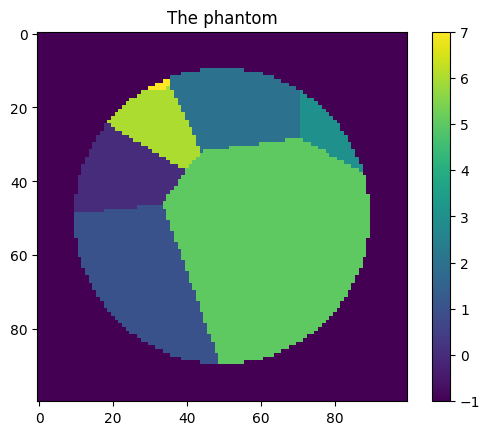

In [442]:
plt.imshow(labels)
plt.colorbar()
plt.title('The phantom')
plt.show()

In [443]:
data_in = ImageData(phantom, geometry=ig_K)
data_out = T.direct(data_in)
data = data_out.as_array().reshape((M_rot, Nx, M_two_theta, M_az))
sigma = 0.0
seed = None
rng = np.random.default_rng(seed)
noise = rng.normal(loc=0.0, scale=sigma, size=data.shape)
noisy = data + noise
noisy = np.clip(noisy, 0, None)  # enforce positivity
data_out = AcquisitionData(noisy.reshape((M_rot, Nx, M)), geometry=ag_M)
data = data_out.as_array().reshape((M_rot, Nx, M_two_theta, M_az))

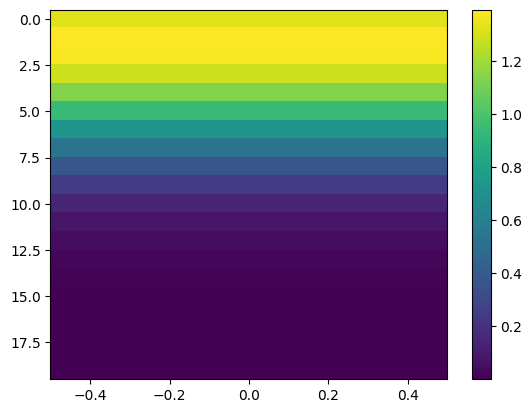

In [444]:
plt.imshow(data[0,60], aspect='auto')
plt.colorbar()

In [445]:
constraint = IndicatorBox(lower=0)
sirt = SIRT(initial=ig_K.allocate(0), operator=T, data=data_out, max_iteration=100, constraint=constraint)
sirt.run(15)
sol = sirt.solution
sol_np = sol.as_array()

/zhome/71/c/146676/miniconda3/envs/cil/lib/python3.11/site-packages/cil/framework/data_container.py:495: RuntimeWarning: divide by zero encountered in power
  out = pwop(self.as_array() , x2 , *args, **kwargs )
100%|█████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.76it/s, objective=0.0959]


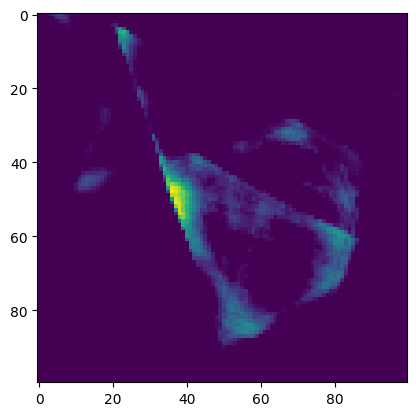

In [446]:
plt.imshow(sol_np[0])

In [447]:
def classify_reconstruction(recovered, true_spectra, metric="l2"):
    """
    Classify each voxel in a reconstructed volume by nearest ground truth spectrum.

    Parameters
    ----------
    recovered : np.ndarray
        Reconstructed volume, shape (K, nx, ny).
    true_spectra : list or np.ndarray
        Array of shape (n_classes, K). Each row is a ground truth spectrum.
    true_labels : np.ndarray
        Label map from phantom, shape (nx, ny).
    mask : np.ndarray or None
        Boolean mask (nx, ny) of valid voxels. If None, all are valid.
    metric : str
        Distance metric: "l2" or "cosine".

    Returns
    -------
    predicted_labels : np.ndarray
        Predicted label map, shape (nx, ny).
    """
    K, nx, ny = recovered.shape
    n_classes = len(true_spectra)

    recovered_flat = recovered.reshape(K, nx*ny).T   # (nx*ny, K)
    print(recovered_flat.shape)

    if metric == "l2":
        dists = (np.abs(recovered_flat[:,None,:] - true_spectra[None, :, :])**2).sum(axis=2)
        #return dists
    elif metric == "l1":
        dists = (np.abs(recovered_flat[:,None,:] - true_spectra[None, :, :])).sum(axis=2)
        #return dists
    else:
        raise ValueError("Unsupported metric")

    # pick nearest spectrum
    pred_flat = np.argmin(dists, axis=1)

    predicted_labels = pred_flat.reshape(nx, ny)


    return predicted_labels-1, dists



(10000, 100)


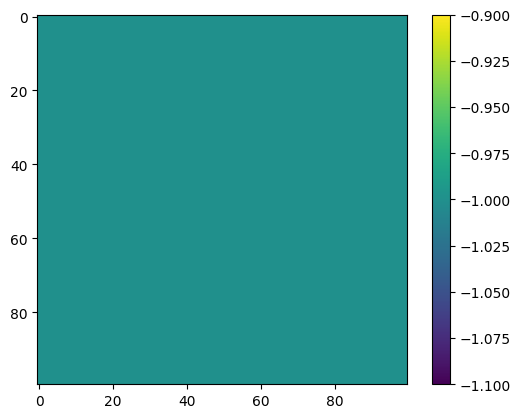

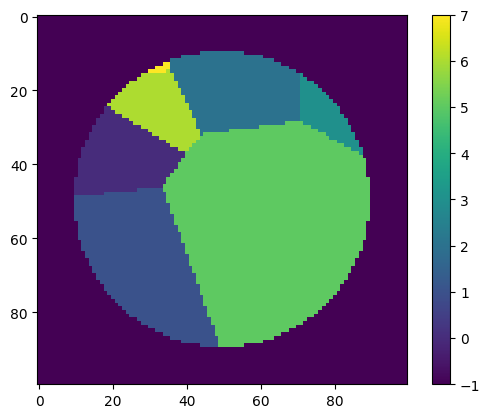

In [448]:
pred_labels, dists = classify_reconstruction(sol_np, true_spectra, metric="l1")
plt.imshow(pred_labels)
plt.colorbar()
plt.show()
plt.imshow(labels)
plt.colorbar()

In [393]:
# add the "outside" zero vector
#true_spectra = np.vstack([true_spectra, np.zeros(phantom.shape[0])])

# classify

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

def plot_labels(true_labels, pred_labels, background_label=-1, base_cmap="tab20"):
    # all classes including background
    classes = sorted(np.unique(np.concatenate([true_labels.ravel(), pred_labels.ravel()])))
    if background_label not in classes:
        classes = [background_label] + classes
    n_classes = len(classes)

    # build colormap: first entry = gray for background, rest from base cmap
    base = plt.cm.get_cmap(base_cmap, n_classes)
    colors = np.vstack([np.array([0.5, 0.5, 0.5, 1.0]), base(np.arange(n_classes))])
    cmap = ListedColormap(colors)

    # mapping from label ID to color index
    label_to_idx = {lab: i for i, lab in enumerate(classes)}

    def remap(arr):
        out = np.full(arr.shape, fill_value=0, dtype=int)  # default = background
        for lab, idx in label_to_idx.items():
            out[arr == lab] = idx
        return out

    true_mapped = remap(true_labels)
    pred_mapped = remap(pred_labels)

    norm = BoundaryNorm(range(n_classes+1), cmap.N)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Ground truth")
    im1 = plt.imshow(true_mapped, cmap=cmap, norm=norm)
    cbar1 = plt.colorbar(im1, ticks=range(n_classes))
    cbar1.ax.set_yticklabels(classes)

    plt.subplot(1, 2, 2)
    plt.title("Predicted")
    im2 = plt.imshow(pred_mapped, cmap=cmap, norm=norm)
    cbar2 = plt.colorbar(im2, ticks=range(n_classes))
    cbar2.ax.set_yticklabels(classes)

    plt.show()


/tmp/ipykernel_3901225/2226395699.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap, n_classes)


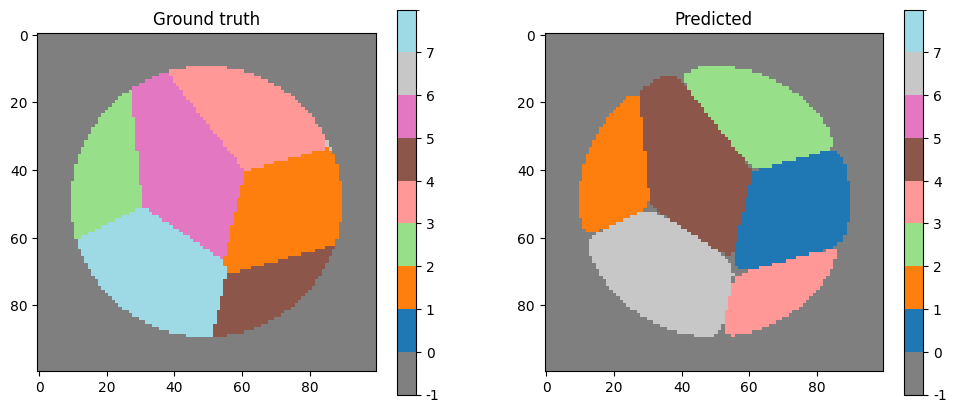

In [369]:
plot_labels(labels, pred_labels, background_label=-1, base_cmap="tab20")

In [71]:
print(labels)

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


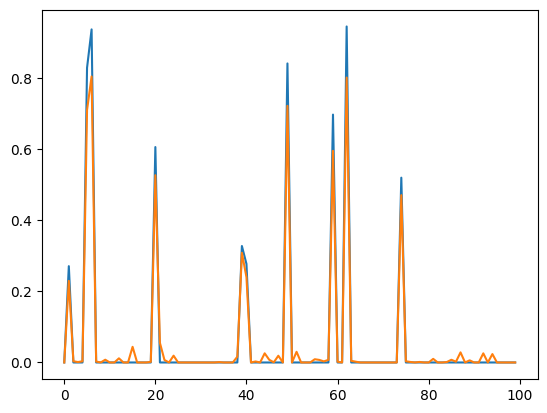

5
4


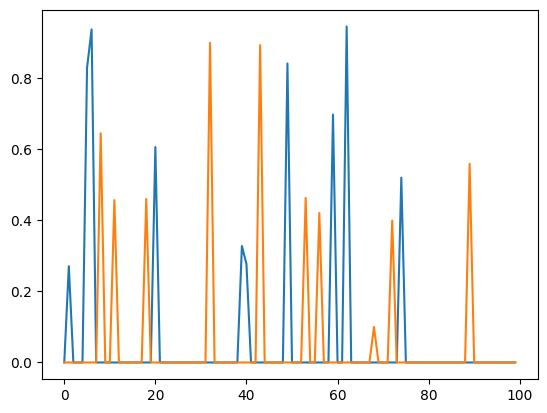

In [56]:
plt.plot(phantom[:,22,70])
plt.plot(sol_np[:,22,70])
plt.show()
print(labels[22,70])
print(pred_labels[22,70])
plt.plot(true_spectra[4])
plt.plot(true_spectra[5])